# MorphoCA codes

This is the code for MorphoCA model simulations and visualization.
## Step 0: import libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, interact, fixed
import ipywidgets as widgets

## Step 1: Delaunay Triangulation

Input variables:
- *nx*: is a $1*N_C$ array, each element represents the x coordinate of the node
- *ny*: is a $1*N_C$ array, each element represents the y coordinate of the node
- *nw*: is a $1*N_C$ array, each element represents the weight of the node

Output variables:
- *ids*: is a matrix with 2 rows and $N_M$ (number of membranes) columns, each column gives the two cell IDs that the cells are adjacent and form the membrane
- *xx*: is a $2*N_M$ matrix, each colum gives two x coordinates for the membrane ends
- *yy*: is a $2*N_M$ matrix, each colum gives two y coordinates for the membrane ends

In [2]:
def DeTri(nx, ny, nw):
    cellnum = len(nx)
    ut = np.triu(np.ones((cellnum, cellnum)), 1)
    id1 = np.ones((cellnum, 1)) * np.arange(1, cellnum + 1)
    id2 = id1.T
    id1 = id1[ut > 0].astype(int) - 1
    id2 = id2[ut > 0].astype(int) - 1
    nx1 = nx[id1]
    ny1 = ny[id1]
    nw1 = nw[id1]
    nx2 = nx[id2]
    ny2 = ny[id2]
    nw2 = nw[id2]
    dx = nx1 - nx2
    dy = ny1 - ny2
    dw = nw1**2 - nw2**2
    dl = np.sqrt(dx**2 + dy**2)
    mx = (nx1 + nx2) / 2
    my = (ny1 + ny2) / 2
    mx = mx - dw * dx / (2 * dl**2)
    my = my - dw * dy / (2 * dl**2)
    d0 = (mx - nx1)**2 + (my - ny1)**2 - nw1**2
    a = (dy*(nx.reshape(-1,1)-mx) - dx*(ny.reshape(-1,1)-my)) / dl
    b = (mx-nx.reshape(-1,1))**2 + (my-ny.reshape(-1,1))**2 - (nw.reshape(-1,1)**2)
    b = b - d0
    j1 = (id1 * len(id1)) + np.arange(len(id1))
    j2 = (id2 * len(id2)) + np.arange(len(id2))
    a.flat[j1] = 1
    a.flat[j2] = -1
    md = np.sqrt(np.maximum(-d0, 0))
    b.flat[j1] = md*2
    b.flat[j2] = md*2
    j0 = np.where(a==0)
    a[j0] = 1
    b[j0] = np.sign(b[j0])*np.max(md)*2
    c = b/a/2
    
    ap = (a > 0)
    am = (a < 0)
    cp = ap * c + (~ap) * md
    cm = am * c - (~am) * md
    cp0 = np.min(cp, axis=0)
    cm0 = np.max(cm, axis=0)
    jj = np.where(cp0 - cm0 > 0)[0]

    vx = dy[jj] / dl[jj]
    vy = -dx[jj] / dl[jj]
    x1 = mx[jj] + vx * cp0[jj]
    x2 = mx[jj] + vx * cm0[jj]
    y1 = my[jj] + vy * cp0[jj]
    y2 = my[jj] + vy * cm0[jj]
    xx = np.vstack((x1, x2))
    yy = np.vstack((y1, y2))
    ids = np.vstack((id1[jj], id2[jj]))

    return ids, xx, yy

## Step 2: compute cell boundaries

Input variables:
- *nx*
- *ny*
- *nw*

Output variables:
- *arcends*: is a matrix with 2 rows and multiple columns, each column includes the two angles of the boundary arc ends
- *arcid*: is an array with the same column number as *arcends*, each element represents the cell IDs that the arc belongs to

In [3]:
def BoundaryCircle(nx,ny,nw):
    cellnum = len(nx)
    nx1 = np.tile(nx,(cellnum,1))
    ny1 = np.tile(ny,(cellnum,1))
    nw1 = np.tile(nw,(cellnum,1))
    nx2 = nx1.T
    ny2 = ny1.T
    nw2 = nw1.T
    dx = nx1-nx2
    dy = ny1-ny2
    dw = nw1**2-nw2**2
    dl = np.sqrt(dx**2+dy**2)+np.eye(cellnum);
    ds = (dl+dw/dl)/2
    dz = np.sqrt(np.maximum(nw1**2-ds**2,0))
    
    ag0 = np.arctan2(dy,dx)
    ag1 = np.arctan2(dz,ds)
    ag1 = ag1*(1-np.eye(cellnum))
    ags = np.tile(ag0,(6,1))+np.concatenate((-ag1-2*np.pi,-ag1,-ag1+2*np.pi,ag1-2*np.pi,ag1,ag1+2*np.pi))
    ags = np.minimum(np.maximum(ags,-np.pi),np.pi)
    bb = np.sort(ags,axis=0)
    cc = (np.argsort(ags,axis=0)>cellnum*3-1)
    e0 = np.arange(0, 6*cellnum-1, 2)
    
    arcend0 = np.array([])
    arcend1 = np.array([])
    arcid = np.array([])
    for ii in range(cellnum):
        c0 = np.where(cc[:,ii]==0)[0]
        c1 = np.where(cc[:,ii]==1)[0]
        c0i = np.where(c0-e0==0)[0]
        c1i = np.where(c1-e0==1)[0]
        c0 = c0[c0i]
        c1 = c1[c1i]
        b0 = bb[c0,ii]
        b1 = bb[c1,ii]
        jj = np.where(b1 - b0 > 0)[0]
        b1 = np.concatenate(([-np.pi], b1[jj]))
        b0 = np.concatenate((b0[jj], [np.pi]))
        jj = np.where(b1 - b0 < 0)[0]
        arcend0 = np.hstack((arcend0,b1[jj]))
        arcend1 = np.hstack((arcend1,b0[jj]))
        arcid = np.hstack((arcid,np.tile(ii,len(jj))))
    arcends = np.vstack((arcend0,arcend1))
    arcid = arcid.astype(int)
    
    return arcends, arcid

## Step 3: plot cells

Input variables:
- *nx*
- *ny*
- *nw*
- *xx*
- *yy*
- *arcends*
- *arcid*

Output figure:
- Cell shapes given by the black lines (membrane between adjacent cells) and arcs (boundary membranes)

In [4]:
def PlotCells(nx,ny,nw,ids,xx,yy,arcends,arcid,xlim,ylim,dual):
    cellnum = len(nx)
    nxc = nx[arcid]
    nyc = ny[arcid]
    nwc = nw[arcid]
    darc = arcends[1,:]-arcends[0,:]
    ags = np.tile(darc,(100,1)) * np.tile(np.linspace(0,1,100),(len(darc),1)).T + arcends[0,:]
    xc = nxc - np.cos(ags)*nwc
    yc = nyc - np.sin(ags)*nwc
    plt.figure
    plt.plot(xx,yy,color='black')
    plt.plot(xc,yc,color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.gca().set_aspect('equal')
    if dual:
        plt.plot(nx[ids],ny[ids],color='blue')
    plt.show()

## Example: plot four cells

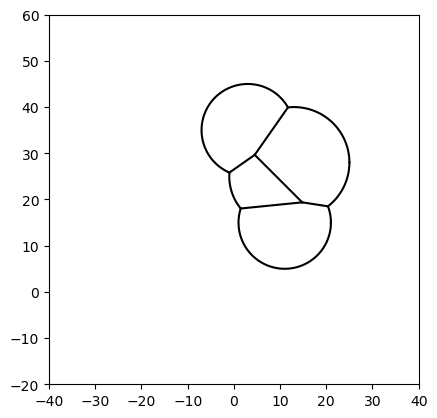

In [5]:
nx = np.array([11,10,3.0,13])
ny = np.array([15,25,35.0,28])
nw = np.array([10,11,10.0,12])
ids, xx, yy = DeTri(nx,ny,nw)
arcends, arcid = BoundaryCircle(nx,ny,nw)
PlotCells(nx,ny,nw,ids,xx,yy,arcends,arcid,[-40,40],[-20,60],False)

## Step 4: compute adjacency matrix

Input variables:
- *nx*
- *ny*
- *nw*
- *ids*
- *xx*
- *yy*
- *arcends*
- *arcid*

Output variables:
- *adj*: the $N_C*N_C$ adjacency matrix, the element is non-zero if the two cells are adjacent, the value represents the membrane length
- *ang*: a $N_C*N_C$ matrix, the $(i,j)$ element represent the angle of the membrane's normal vector towards cell $i$
- *vol*: a $1*N_C$ array, each element represents the volume of the cell

In [6]:
def Adjacency(nx,ny,nw,ids,xx,yy,arcends,arcid):
    cellnum = len(nx)
    adj = np.zeros((cellnum,cellnum))
    ang = np.zeros((cellnum,cellnum))
    vol = np.zeros(cellnum)
    dl = np.sqrt((xx[1,:]-xx[0,:])**2 + (yy[1,:]-yy[0,:])**2)
    dx = nx[ids[0,:]]-nx[ids[1,:]]
    dy = ny[ids[0,:]]-ny[ids[1,:]]
    ag = np.arctan2(dy,dx)
    k1 = (ids[0,:] * cellnum) + ids[1,:]
    k2 = (ids[1,:] * cellnum) + ids[0,:]
    adj.flat[k1] = dl
    adj.flat[k2] = dl
    ang.flat[k1] = ag
    ang.flat[k2] = ag-np.pi
    
    for ii in range(len(arcid)):
        vol[arcid[ii]] += .5*(arcends[1,ii]-arcends[0,ii])*nw[arcid[ii]]**2
    for ii in range(len(ids[0,:])):
        cid = ids[:,ii]
        dx0 = xx[0,ii]-nx[cid]
        dx1 = xx[1,ii]-nx[cid]
        dy0 = yy[0,ii]-ny[cid]
        dy1 = yy[1,ii]-ny[cid]
        vv = (dx0*dy1-dx1*dy0)/2
        vol[cid[0]] -= vv[0]
        vol[cid[1]] += vv[1]
    
    return adj, ang, vol

## Step 5: function of sensor

Input variables:
- *M*: the molecule matrix of $N_C$ columns and $N_{mol}$ (number of molecules) rows. Each element is between 0 and 1
- *adj*: the adjacency matrix
- *ang*: the adjacent-angel matrix

Output variables:
- *gMx*: the x-gradiant of molecules from neighbor, the matrix size is $N_{mol}*N_C$
- *gMy*: the y-gradiant of molecules from neighbor, the matrix size is $N_{mol}*N_C$
- *sM*: the sum of molecule information from neighbor, the matrix size is $N_{mol}*N_C$

In [7]:
def Sensor(M,adj,ang):
    molnum = len(M[:,0])
    cellnum = len(M[0,:])
    adj0 = np.sign(adj)
    gMx = np.zeros((molnum,cellnum))
    gMy = np.zeros((molnum,cellnum))
    dMx = np.zeros((molnum,cellnum))
    dMy = np.zeros((molnum,cellnum))
    sM = np.zeros((molnum,cellnum))
    for ii in range(molnum):
        gMx[ii,:] = np.sum(M[ii,:]*adj*np.cos(ang),axis=1)
        gMy[ii,:] = np.sum(M[ii,:]*adj*np.sin(ang),axis=1)
        dMx[ii,:] = np.sum(M[ii,:]*adj0*np.cos(ang),axis=1)
        dMy[ii,:] = np.sum(M[ii,:]*adj0*np.sin(ang),axis=1)
        sM[ii,:] = np.sum(M[ii,:]*adj,axis=1)
    
    return gMx, gMy, dMx, dMy, sM

## Step 6: function of controller

Input variables:
- *M*
- *nx*
- *ny*
- *nw*
- *vol*

Output variables:
- *nx*: the updated x-coordinate of nodes
- *ny*: the updated y-coordinate of nodes
- *nw*: the updated weight of nodes

Function parameters:
- *dx*, *dy*: moving steps of nodes
- *dw*: changes steps of weights
- *v0*: the target cell volume

In [8]:
def Controller(M,nx,ny,nw,vol):
    dx = 0.2
    dy = 0.2
    dw = 0.2
    v0 = 250
    nx += (M[2,:]-.5)*dx
    ny += (M[3,:]-.5)*dy
    nw += ((v0-vol)/v0+(M[4,:]-.5))*dw
    
    return nx, ny, nw

## Step 7: CA updating rules

Input variables:
- *M*: the molecule matrix of $N_C$ columns and $N_{mol}$ (number of molecules) rows. Each element is between 0 and 1
- *gMx*: the x-gradiant of molecules from neighbor, the matrix size is $N_{mol}*N_C$
- *gMy*: the y-gradiant of molecules from neighbor, the matrix size is $N_{mol}*N_C$
- *sM*: the sum of molecule information from neighbor, the matrix size is $N_{mol}*N_C$

Output variables:
- *M*: the updated molecule matrix

In [9]:
def AutomataRule(M,gMx,gMy,dMx,dMy,sM):
    M[2,:] = (gMx[0,:]-10*dMx[0,:])*0.1+0.5
    M[3,:] = (gMy[0,:]-10*dMy[0,:])*0.1+0.5
    M = 1/(1+np.exp(.5-M))
    return M

## Example: cell movement

Setup:
- *nx*: initial x-coordinate of nodes
- *ny*: initial y-coordinate of nodes
- *nw*: initial weight of nodes
- *M*: initial molecule levels
- *timenum*: number of time steps

Results:
- *nxs*: the dynamics of *nx*, each row is *nx* at one time step
- *nys*: the dynamics of *ny*, each row is *ny* at one time step
- *nws*: the dynamics of *nw*, each row is *nw* at one time step

In [10]:
def CellInitial(cx,cy):
    nx = np.arange(cx)
    ny = np.arange(cy)
    nx = np.tile(nx,(cy,1))
    ny = np.tile(ny,(cx,1))
    nx = np.reshape(nx,cx*cy)
    ny = np.reshape(ny.T,cx*cy)
    nx = np.random.rand(cx*cy)*3+nx*10
    ny = np.random.rand(cx*cy)*3+ny*10
    nw = np.random.rand(cx*cy)*3+10
    return nx, ny, nw

In [11]:
nx,ny,nw = CellInitial(3,4)

cellnum = len(nx)
timenum = 8000
nxs = np.zeros((timenum,cellnum))
nys = np.zeros((timenum,cellnum))
nws = np.zeros((timenum,cellnum))
nxs[0,:] = nx
nys[0,:] = ny
nws[0,:] = nw
M = np.ones((5,cellnum))*0.5
for ii in range(timenum-1):
    ids, xx, yy = DeTri(nx,ny,nw)
    arcends, arcid = BoundaryCircle(nx,ny,nw)
    adj,ang,vol = Adjacency(nx,ny,nw,ids,xx,yy,arcends,arcid)
    gMx,gMy,dMx,dMy,sM = Sensor(M,adj,ang)
    M = AutomataRule(M,gMx,gMy,dMx,dMy,sM)
    nx,ny,nw = Controller(M,nx,ny,nw,vol)
    nxs[ii+1,:] = nx
    nys[ii+1,:] = ny
    nws[ii+1,:] = nw


### The interactive visualization

Move the slider to change time.

In [12]:
def MorphoShape(t,xlim,ylim,dual):
    nx = nxs[t,:]
    ny = nys[t,:]
    nw = nws[t,:]
    ids, xx, yy = DeTri(nx,ny,nw)
    arcends, arcid = BoundaryCircle(nx,ny,nw)
    PlotCells(nx,ny,nw,ids,xx,yy,arcends,arcid,xlim,ylim,dual)

interact(
    MorphoShape,
    t=widgets.IntSlider(min=0,max=timenum-1,step=1,value=0),
    xlim=widgets.IntRangeSlider(min=-100,max=100,step=1,value=[-40,60]),
    ylim=widgets.IntRangeSlider(min=-100,max=100,step=1,value=[-30,70]),
    dual = widgets.Checkbox(value=False)
);

interactive(children=(IntSlider(value=0, description='t', max=7999), IntRangeSlider(value=(-40, 60), descripti…

In [13]:
print(vol)

[250.00165957 250.00707628 250.00489973 250.01034652 250.02211224
 250.00776728 250.01919689 250.02053351 250.02193272 250.01235133
 250.01544788 250.00320437]
